# Install packages
Some packages still have to be installed, like SHAP, hdbscan, umap-learn and skope-rules


In [1]:
%%capture
!pip install shap hdbscan umap-learn skope-rules scikit-learn==1.3.0

Load git repo to have access to data.

In [2]:
!git clone https://github.com/mazych/intro-to-explainabilty-in-finance-oct2024

fatal: destination path 'intro-to-explainabilty-in-finance-oct2024' already exists and is not an empty directory.


# Import packages

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb


import shap
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.inspection import PartialDependenceDisplay

import hdbscan
import umap
import numpy as np
from typing import Any, Tuple, Dict, List
from sklearn.base import BaseEstimator
# workaround for iterable error while importing skrules
import collections.abc
import sklearn
import six
collections.Iterable = collections.abc.Iterable
sklearn.externals.six = six
from skrules import SkopeRules

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Introduction

In this workshop, we'll work on a use case involving customer churn prediction. We'll use EDA to explore the dataset and SHAP for interpreting the model's predictions, helping us understand why customers might leave and if the predicts correctly. <br><br>

**EDA & Interpretability: Why We Need Both**
* Exploratory Data Analysis (EDA) helps us understand the structure and patterns in our data. Interpretability, on the other hand, ensures that our models' inner workings and predictions are understandable and trustworthy. Combining EDA with interpretability techniques allows for more informed decision-making and reliable insights, as the findings from EDA should be reflected in the model's logic. This approach enables us to audit models and to better explain results to stakeholders.

**Methods for EDA & Interpretability**
* Common EDA methods include summary statistics, data visualization (such as histograms, scatter plots), heat maps and correlation analysis. For interpretability, methods are often divided into local and global approaches. Local interpretability focuses on explaining individual predictions, while global interpretability looks at overall model behavior. Examples include feature importance, partial dependence plots, and SHAP (SHapley Additive exPlanations), which we use for this workshop due to its widespread adoption. Links for further details will be provided at the end of the notebook for those interested in exploring further.

**SHAP: High-Level Overview**
* SHAP is a method that explains individual predictions by attributing each feature’s contribution to the output. It builds on concepts from game theory, specifically Shapley values, to fairly distribute the total prediction among the contributing features. This ensures consistent, interpretable, and fair explanations by considering all possible feature combinations. While SHAP is primarily a local explanation method—providing insights into single predictions—it can also be aggregated across many predictions to create global explanations, offering insights into overall model behavior.  
It’s important to note that SHAP shows correlations between features and model predictions, but it [does not imply causal relationships](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html).  
For a more [detailed explanation of SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).


# The mortgage churn dataset

We will use a dataset of customers of a random bank. The dataset contains information on the mortgage churn of customers. Besides the dataset consists of data on characteristics of the customer but also information on the mortgage. <br><br>


####**!!! IMPORTANT !!!**
This data is *generated* for the purpose of this workshop. The dataset:
* doesn't include any customers of ABN AMRO
* isn't a represenation of the population of customers at ABN AMRO  

Credits: dataset is adapted based on: https://archive.ics.uci.edu/dataset/34/diabetes

**The data contains the following features:**

|Feature                      | Description   |
|:----------------------------|:--------------|
|churn                        | If the customer has churned on the mortgage (0 = no, 1 = yes)
|activity level               | Activity related to mortgages on the web/mobile of the bank (1 = lowest -  5 = highest)|
|parties_count                | Number of parties involved into the mortgage contract (1 - 2)|
|years_until_frp              | Years until fixed rate period ends (in years)|
|recently_contacted           | If the customer contacted the bank. (0 = no, 1 = yes)
|recently_changed_energy level| If the customer had changes in energy level in the past 6 month. (0 = no, 1 = yes)|
|recently_took_loan           | If the customer has recently obtained a loan from the bank. (0 = no, 1 = yes)|
|age                          | Age of the customer (in years)|
|used_calculator              | If a customer have recently used a mortgage calculator tool (0 = no, 1 = yes)|
|customer_before_mortgage     | If the customer were a also a customer of the bank before obtaining a mortgage product. (0 = no, 1 = yes)|
|market_value                 |The current market value of the property. (1=  lowest -  8 = highest)|
|missed_payment               |If the customer had missed a payment at least once (0 = no, 1 = yes)|
|city_size                    |The cize of the city where the property is located.  (1 = smallest -  6 = highest)|
|balance                      |Amount of money left to pay off (in euro) - this feature is created to imitate a leaky feature|

<br>

**Target variable**\
Churn is our target variable in this workshop.<br><br>

**Other remarks on the data**
* All data is ordered.
* Age and balance are continuous, rest is ordinal or binary.
* The dataset has already been cleaned, so no extra transformations are needed.
<br>

**Exercises**\
Most of exercises are interpretation of our results. However, at some places you will be asked to fill in variables to learn how to use shap plot. They are marked with a ⭐.

In [5]:
df = pd.read_csv('/content/intro-to-explainabilty-in-finance-oct2024/workshop/mortgage_churn.csv',index_col=0)
df.head()

,churn,activity_level,parties_count,years_until_frp,recently_contacted,recently_changed_energy_label,recently_took_loan,age,used_calculator,customer_before_mortgage,market_value,missed_payment,city_size,balance
0,0.0,3.0,2.0,10.0,0.0,0.0,0.0,39.0,0.0,0.0,8.0,0.0,6.0,415125.475902
1,0.0,3.0,1.0,2.0,0.0,0.0,0.0,39.0,0.0,0.0,8.0,1.0,6.0,390089.055674
2,0.0,1.0,2.0,1.0,0.0,0.0,0.0,39.0,0.0,0.0,8.0,0.0,6.0,298295.013024
3,0.0,3.0,1.0,3.0,0.0,0.0,0.0,41.0,0.0,0.0,8.0,0.0,6.0,344079.729885
4,0.0,2.0,2.0,6.0,0.0,0.0,0.0,42.0,0.0,1.0,8.0,0.0,5.0,180832.760267


# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA)
Explanation: In this part of the workshop, we will take a closer look at the data and its distribution. EDA helps us uncover patterns, spot anomalies, and test hypotheses. We will focus on three main activities:

* **Explore Descriptives**:
We will examine summary statistics like mean, median, standard deviation, and range to understand the central tendency and dispersion of features.
* **Explore Plots Between Features and the Target Variable**: We will create visualizations such as scatter plots, box plots, and bar charts to see relationships between features and the target variable. This helps us identify trends and potential predictors.
* **Explore Correlations**: We will analyze the relationships between different features using correlation matrices and heatmaps. This helps us understand how features interact with each other and identify multicollinearity issues.

<a id="EDA"></a>
## EDA: Plots features versus target variable
Let's explore the connections between features and the target variable.

<Figure size 1000x800 with 0 Axes>

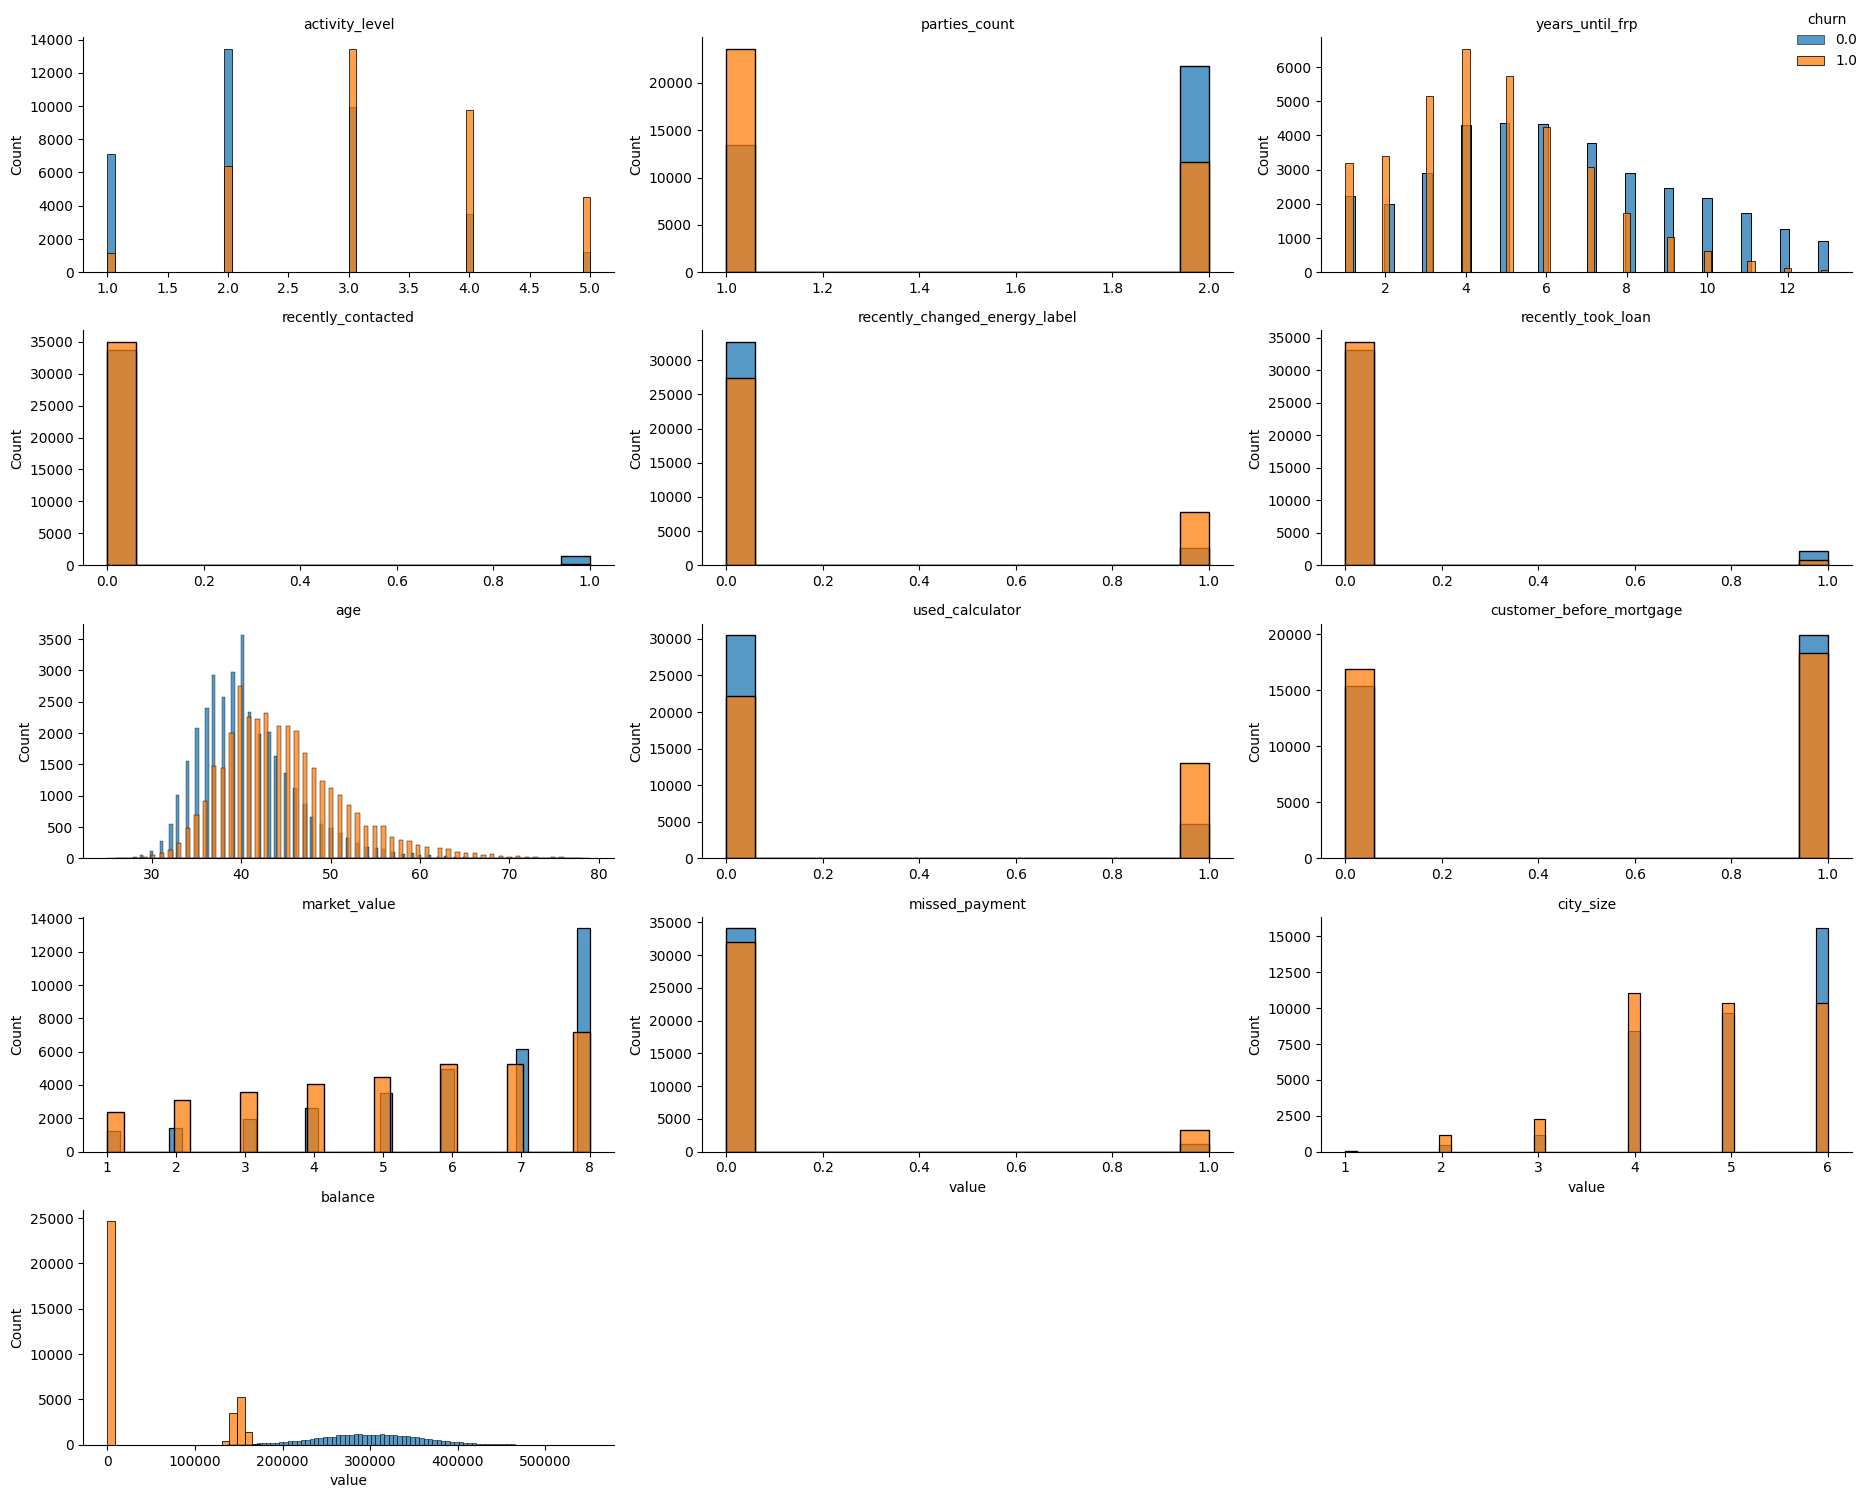

In [6]:
def create_facet_grit_hist(df, target='churn', multiple='layer'):
    """
    Create a facet grid of histograms of all features in the dataset,
    where we compare the target outcome.

    Args:
        df (dataFrame): Input dataset
        target (str): Target column name
        multiple (str): Approach how the graph should be shown; 'layer' or 'dodge'

    Returns:
        Nothing
    """

    df_melted = pd.melt(df, id_vars=target, value_vars=[col for col in df.columns if col != target])
    df_melted['value'] = df_melted['value'].astype(int)

    plt.figure(figsize=(10, 8))
    graphs = sns.FacetGrid(df_melted,
                           col='variable',
                           hue=target,
                           col_wrap=3,
                           sharey=False,
                           sharex=False,
                           aspect=2)

    graphs.map(sns.histplot, 'value', kde=False, element='bars', stat='count', multiple='dodge')

    # Add legend and titles
    graphs.add_legend(title=target, loc='upper right')
    graphs.set_titles(col_template="{col_name}")

    plt.tight_layout()
    plt.show()

# Usage
create_facet_grit_hist(df=df, target='churn', multiple='layer')


<Figure size 800x800 with 0 Axes>

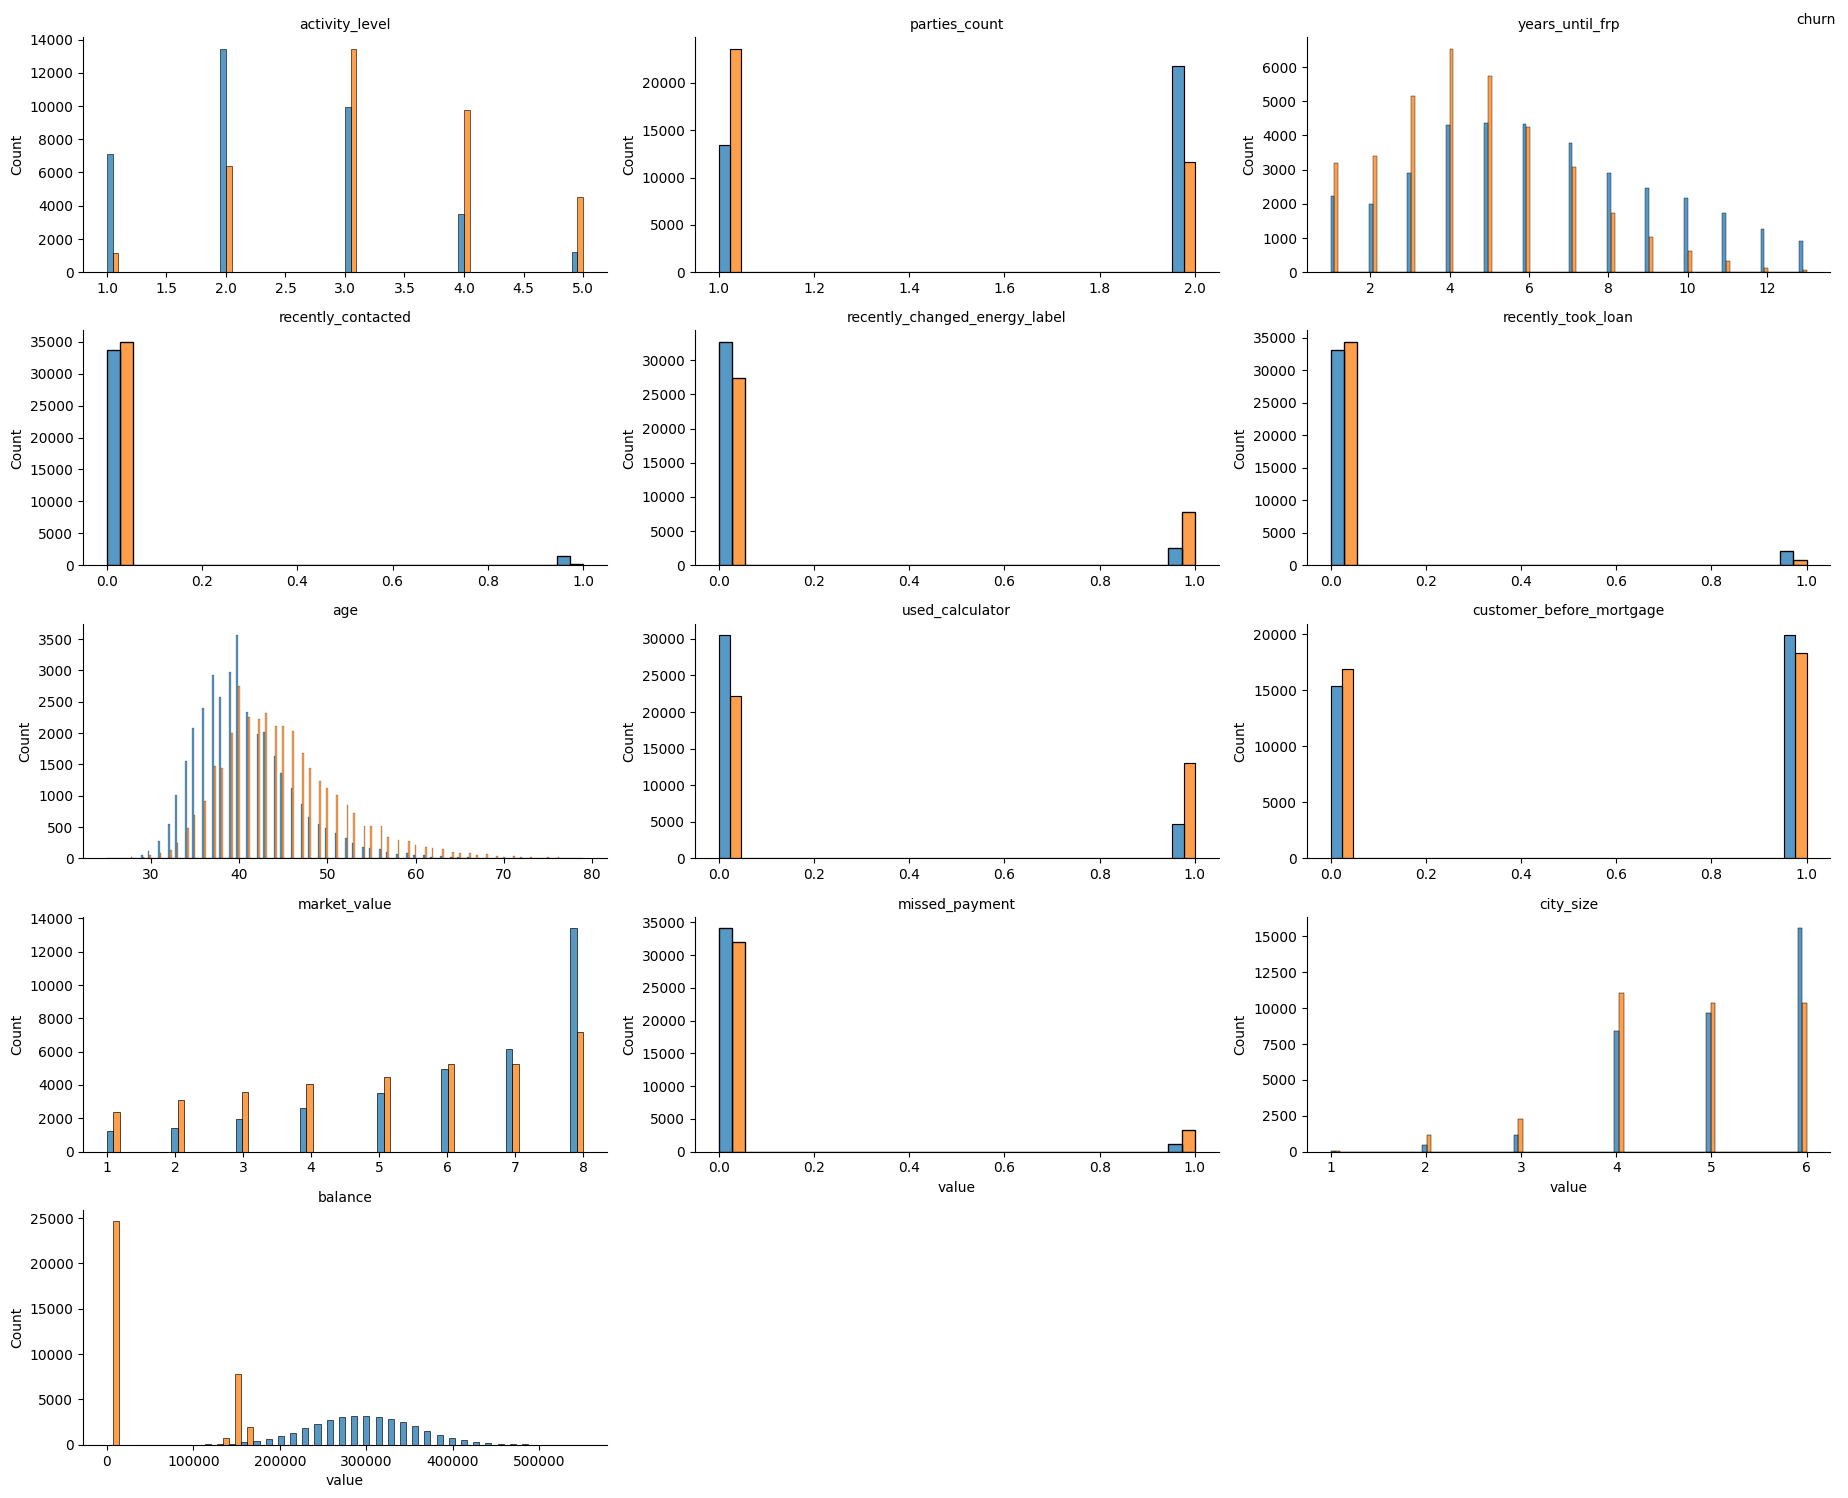

In [7]:
def create_facet_grit_hist(df, target='churn', multiple='layer'):
    """
    Create a facet grit of histograms of all features in the dataset,
    where we compare the taget outcome.

    Args:
        df (dataFrame): Input dataset
        target (str): Target column name
        multiple (int): Approach how the graph should be shown; stacked or layered

    Returns:
        Nothing
    """

    df_melted = pd.melt(df, target, df.columns)
    df_melted['value'] = df_melted['value'].astype(int)
    plt.figure(figsize = (8,8))
    graphs = sns.FacetGrid(df_melted,
                          col = 'variable',
                          #  hue = target,
                          col_wrap = 3,
                          sharey = False,
                          sharex = False,
                          aspect = 2)
    graphs.map_dataframe(sns.histplot,
                        x='value',
                        kde=False,
                        element='bars',
                        stat='count',
                        # multiple = multiple,
                        multiple='dodge',  # Use 'dodge' to separate bars
                        hue = target#,
                        # discrete = True --> takes ages to run..
                         )

    #graphs.add_legend()

        # Add legend and titles
    graphs.add_legend(title=target, loc='upper right')
    graphs.set_titles(col_template="{col_name}")
    plt.tight_layout()
    plt.show()

create_facet_grit_hist(df=df, target='churn', multiple='layer')

<details>
<summary><b>Discussion of Results</b></summary>  

**What relationships do we see between feature and the target variable from the plots?**
* Balance, less - more likely to churn. We can clearly see here that balance is fully predictive. This is our leaky feature with information about mortgage balance left at the account, that would not be there at the time of prediction.
* More activity level, more likely to churn
* Less parties involved, more likely to churn
* Years until fixed rate period, less years more likely to churn
* If recenttly energy label changed, then more likely to churn
* If recently took loan, then more likely to churn
* Older people, more likely to churn
* Used calculator, more likely to churn
* Customer before mortgage - if not, more likely to churn
* Higher market value, less likely to churn
* Bigger city, less likely to churn
</details>




## **EDA: Correlations**  

Let's use Spearman correlations to have a closer look at the correlations between features. We use the Spearman correlation.

 Spearman correlation evaluates how well the relationship between the variables can be described using a monotonic function. Spearman correlation requires at least two variables that can be either ordinal or continuous. The Spearman correlation coefficient ranges from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation. The Spearman correlation is considered weak when the correlation coefficient is close to 0.

* Weak correlation: ( -0.3 corr < 0.3 )  
* Moderate correlation: (-0.5 < corr < -0.3 or 0.3 < corr < 0.5 )  
* Strong correlation: ( -0.5 < or > 0.5 )  


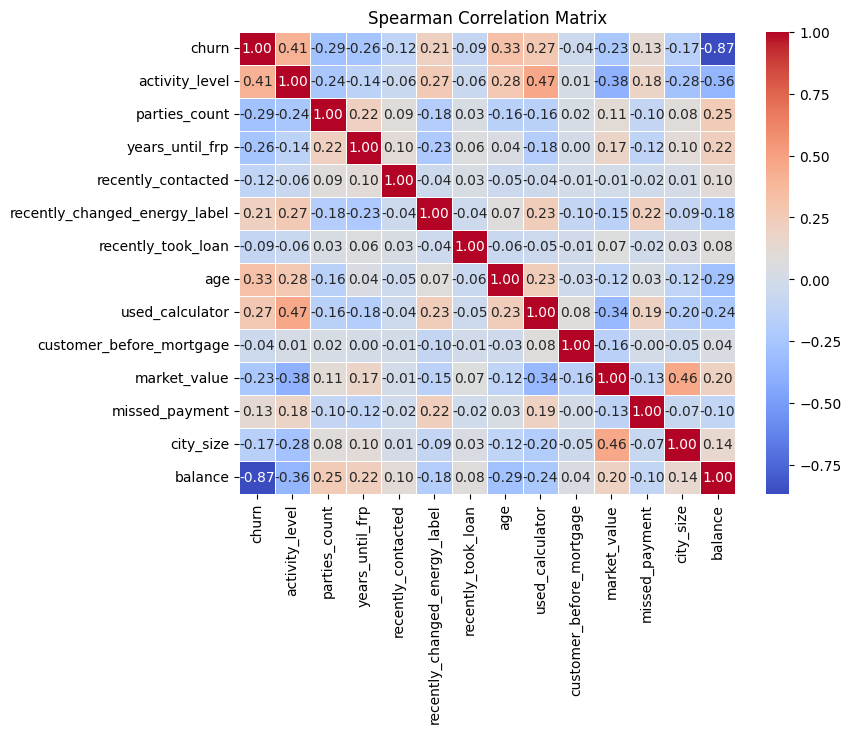

In [8]:
# Calculate the correlation matrix using Spearman's rank correlation.
# You can fill in the data you want to analyze by replacing 'df' with your DataFrame.

corr_matrix = df.corr(method='spearman') # fill in data you want to see

plt.figure(figsize=(8, 6))
# Create a heatmap to visualize the correlation matrix.
# 'annot=True' displays the correlation values on the heatmap.
# 'cmap="coolwarm"' sets the color map for the heatmap (you can change this if needed).
# 'linewidths=0.5' adds space between the squares, making the heatmap more readable.
# 'fmt=".2f"' ensures the correlation values are formatted to two decimal places.
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt='.2f')
plt.title("Spearman Correlation Matrix")
plt.show()

<details>
<summary>What do we notice from the correlation matrix?</summary>  

**What do we notice from the correlation matrix?**\
The Spearman correlation matrix, shows a very high correlation between balance and churn. This is our leak feature so we know the reason for this high correlation: balance after churning vs before. In normal situation this needs to be investigated before building a model.

Besides that we have moderately correlated features in the dataset.

*Positively moderately correlated:*
* used_calculator and activity_level
* city_size and market_value  

*Negatively moderately correlated:*
* market_value and activity_level
* market_value and used_calculator
</details>

# Model
Many different models can be used for this specific use case. However, we will use XGBoost as it works well with our type of data and runs **fast** with the SHAP library when producing explanations (see exercise 1). If you're interested, you can check always for yourself later on how fast SHAP works with other models.

*Remark:*<br>
We have seen before that balance is a suspicious feature, but for this exercise let's ignore it for now. Let's see how the model will look with and without the feature balance.  

## Model: XGBoost

In [9]:
# This is the model **with** using the 'balance' feature

# Splitting the dataset into features (X) and target variable (y)
# Here, 'churn' is the target variable we are predicting
X = df.drop(['churn'],axis=1)
y = df['churn']
# Splitting the data into training and test sets (80% train, 20% test)
# 'random_state=42' ensures reproducibility of the train-test split
X_train_b, X_test_b, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the XGBoost classifier with the training set
xg_cls_b = xgb.XGBClassifier().fit(X_train_b, y_train)
# Predicting the labels for the test set
y_pred_b = xg_cls_b.predict(X_test_b)

# Generating and printing the classification report, which includes precision, recall, f1-score, and support
class_report = classification_report(y_test, y_pred_b)
print("\nClassification Report with balance feature:")
print(class_report)


# This is the model **without** using the 'balance' feature

# Dropping the 'balance' feature from the training and test sets
X_train = X_train_b.drop(['balance'], axis=1)
X_test = X_test_b.drop(['balance'], axis=1)
# Training the XGBoost classifier on the modified dataset (without 'balance')
# Initialize a tuned XGBoost classifier with specific hyperparameters
# These parameters include:
# - colsample_bytree: The fraction of features to randomly sample for each tree
# - learning_rate: The step size at each iteration (controls how quickly the model learns)
# - max_depth: The maximum depth of each tree
# - n_estimators: The number of trees (boosting rounds)
# - subsample: The fraction of samples to use for training each tree (helps prevent overfitting)
xg_cls = xgb.XGBClassifier(colsample_bytree= 0.9, learning_rate= 0.1, max_depth= 4, n_estimators= 150, subsample= 0.8, random_state=42).fit(X_train, y_train)
y_pred = xg_cls.predict(X_test)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report without balance feature:")
print(class_report)


Classification Report with balance feature:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7090
         1.0       0.99      1.00      0.99      7014

    accuracy                           0.99     14104
   macro avg       0.99      0.99      0.99     14104
weighted avg       0.99      0.99      0.99     14104


Classification Report without balance feature:
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      7090
         1.0       0.72      0.80      0.76      7014

    accuracy                           0.75     14104
   macro avg       0.75      0.75      0.74     14104
weighted avg       0.75      0.75      0.74     14104



**What do we notice from the classfication reports of the model?**<bR>
Using balance gives us 99% accuracy, which is very unlikely. In real world data this does not really happen. The model without balance seems more realistic.  


## Model: Feature importance
In this part we look at the XGBoost feature importance. Again we look at the feature importance of the model with and without balance.

**What is feature importance in XGBoost?**<br>
Feature importance in tree models indicates the relative contribution of each feature to the model's accuracy, helping to identify which variables are most influential in driving the output.

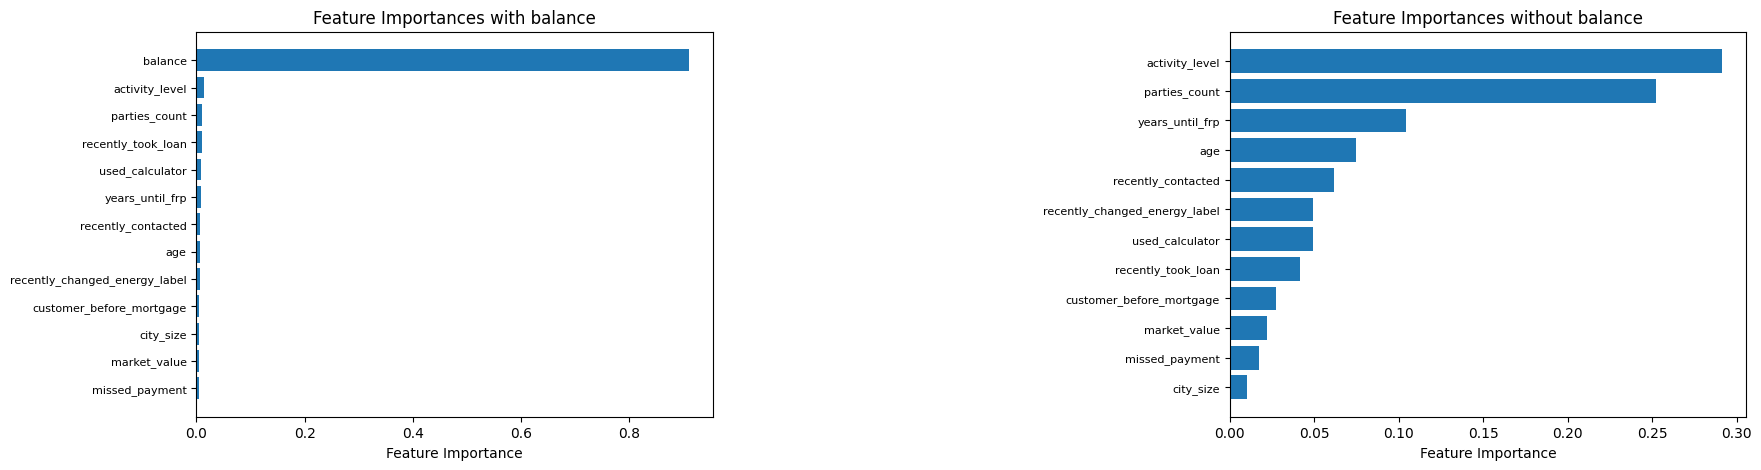

In [10]:
# Titles for the two plots (with and without the 'balance' feature)
titles = [' with balance', ' without balance']
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# Loop through the two models and their corresponding feature sets
for i, (model, feature_names) in enumerate(zip([xg_cls_b, xg_cls], [X.columns, X_train.columns])):
    # Get the feature importance from the model
    feature_importance = model.feature_importances_
    # Create a DataFrame to hold feature names and their corresponding importance scores & sort
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
    plt.subplot(1,2,i+1)
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances'+titles[i])
    plt.yticks(fontsize=8)
plt.subplots_adjust(wspace=1)
plt.show()




<details>
<summary>What do we notice from the feature importance?</summary>

**What do we notice from the feature importance?**<br>
*Feature importance with balance:*<br>
Balance is really a dominant feature. The feature importance value of balance is > 0.9. This means that it significantly predicts the target variable of churn. The feature importance of the other features is low.


*Feature importance without balance:*<br>
If balance is not included in the model then the feature importance shows a different graph. Now, activity_level is the most important feature with a feature importance value around 0.4. Activity_level is followed by parties_count.


These results show us that first model reliance on a single feature masks the true complexity of the problem and results in a model that is not genuinely reflective of real-world scenarios.
</details>

# 1. Exercise One: Introduction to SHAP Visualizations
<!-- SHAP (SHapley Additive exPlanations) is derived from game theory and it provides a framework for interpreting machine learning models. SHAP values provide insights into how different features influence the output of your model, allowing for a better understanding of model behavior and decision-making. SHAP can be applied to any machine learning model. It helps in identifying which features are driving predictions and enhancing transparency and trust in AI.<br><br>-->

After this exercise you will have some familiarisation with SHAP plots and comparing it with EDA (Exploratory Data Analysis).

## 1.1 SHAP for leaky feature detection
In this exercise, you will compare SHAP plots to insights from EDA looking on the impact of a leaky feature in the dataset. The goal is to observe how SHAP values reflect feature importance and compare it to what we have seen in EDA and model performance. By comparing the plots, you’ll understand the effects of data leakage and how removing this feature alters the feature importance and improves the model's robustness.

**⭐ Exercise:**<br>
Generate two SHAP summary plots:
* one for a model trained with the leaky feature (X_train_b)
* another without it (X_train).  <br>

For SHAP to show us distribution of SHAP values, we need:
* samples of the dataset that need to be filled in dataShap and
* provide the model to be explained.

The dataset you can use can be your test or training sample, random subsample or even whole dataset. Note that the bigger data sample the longer it will run. For this exercise we will use train.sample(1000) or test sample.

As **reminder**, we have following variables with balance feature and without: X_test_b, X_train_b, xg_cls_b, X_test, X_train, xg_cls

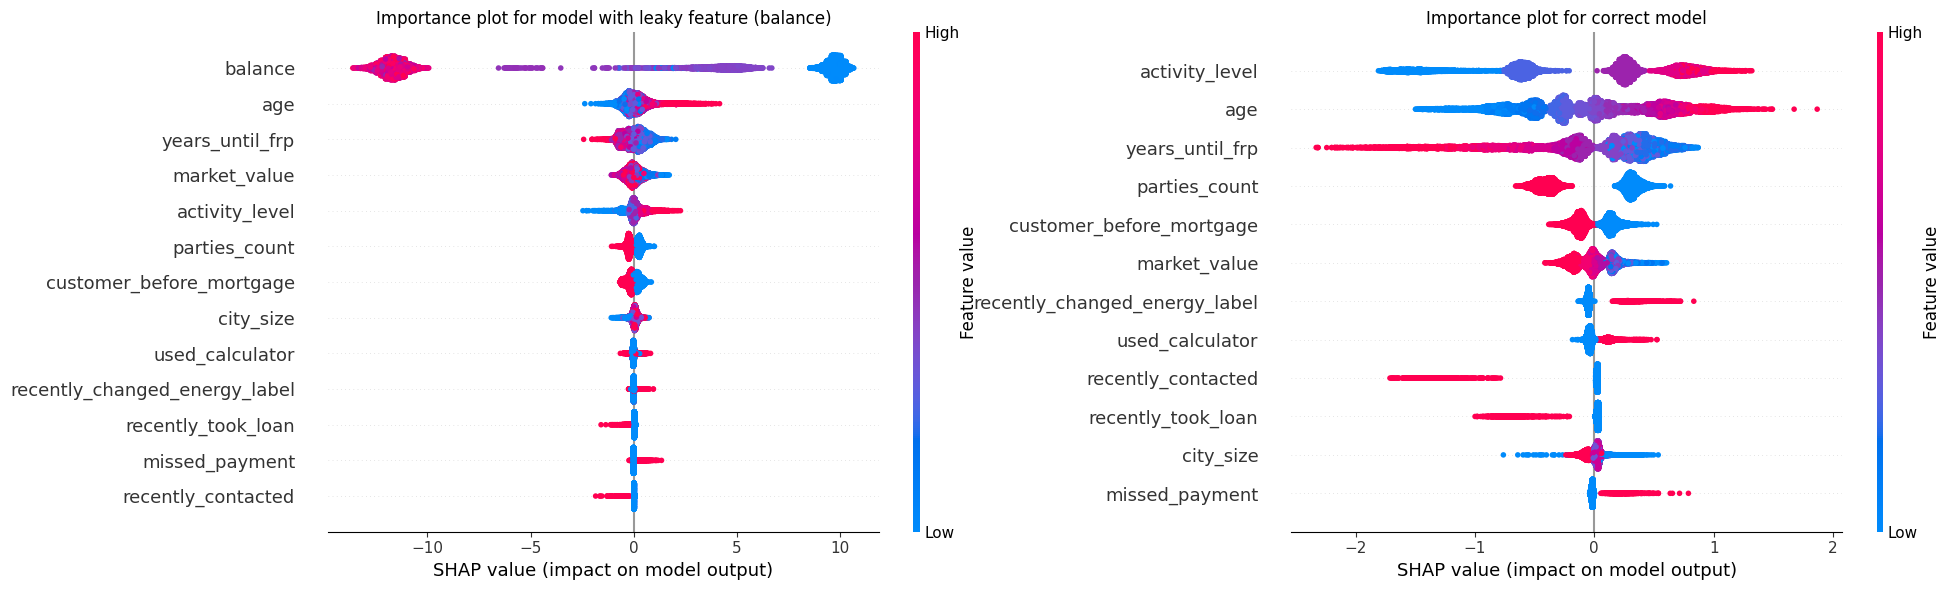

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1,2,1)
# Data subset that you want to visualize for SHAP values (including 'balance' feature)
dataShap_b = X_test_b ## EXERCISE: Fill with data subset that you want to visualise for features including balance
# Create a SHAP explainer for the model trained with 'balance'
explainer_b = shap.TreeExplainer(xg_cls_b) ## EXERCISE: Fill corresponding trained model name
# Calculate SHAP values for the data
shap_values_all_b = explainer_b(dataShap_b)
# Extract the SHAP values from the explanation object
shap_values_b = shap_values_all_b.values
# Generate the SHAP summary plot (with 'balance')
# 'show=False' ensures the plot is not displayed until plt.show() is called at the end
shap.summary_plot(shap_values_b, dataShap_b, plot_size=None, show=False)
plt.title('Importance plot for model with leaky feature (balance)')
# Subplot for the model **without** the 'balance' feature
plt.subplot(1,2,2)
dataShap = X_test ## EXERCISE: Fill with data subset that you want to visualise for features without balance feature
explainer = shap.TreeExplainer(xg_cls) ## EXERCISE: Fill corresponding trained model name
shap_values_all = explainer(dataShap)
shap_values = shap_values_all.values
shap.summary_plot(shap_values, dataShap, plot_size=None, show=False)
plt.title('Importance plot for correct model')
plt.show()

<details>
<summary>Discussion of the results</summary>

**Discussion of the results** <br>
The SHAP summary plots rank features from most to least important based on their contribution to the model's predictions. In the plots, blue represents low feature values, while red represents high feature values. The right side of the plot shows the features pushing predictions towards customer churn, while the left side indicates non-churn. SHAP helps us visualize how the model is making decisions. <br><br>

*Left SHAP summary plot:*<br>
* The SHAP values for the "balance" feature align with the trend we observed in the EDA, reflecting its distribution.
* In contrast, other features on the left plot appear compressed, indicating lower importance or less variability in their influence on the model's output.<br><br>


*Right SHAP summary plot:*<br>
* Like in the feature importance, without balance, the SHAP values of the other features are less compressed.
* Activity_level is ranked as most important.
* Age and years_until_frp can be considered as important.
</details>

## 1.2 SHAP single explanation
In exercise 1.1 we have looked at the SHAP values on the total dataset. This is also known as global SHAP. SHAP also provides the possibility to look at an individual level, i.e. local SHAP.
because 'global' is just all these single explanations plotted and ordered by mean absolute value of the SHAP values for each feature. In this exercise we visualize local SHAP for three different customers.<br>

⭐ Exercise: <br>
We’ve gathered the indices of misclassified, churned, and non-churned samples for you, which you can find in the loop. Please refer to the *samples* section in line 7 for more details. Your job is to
fill samples in the waterfall plot. <br>
Tip: waterfall plot needs more information than just shap_values themselves. Print beforehand *shap_values_all* and
*shap_values* to explore what they hold inside. <br>
Check as well what happens when we use a leaky model!

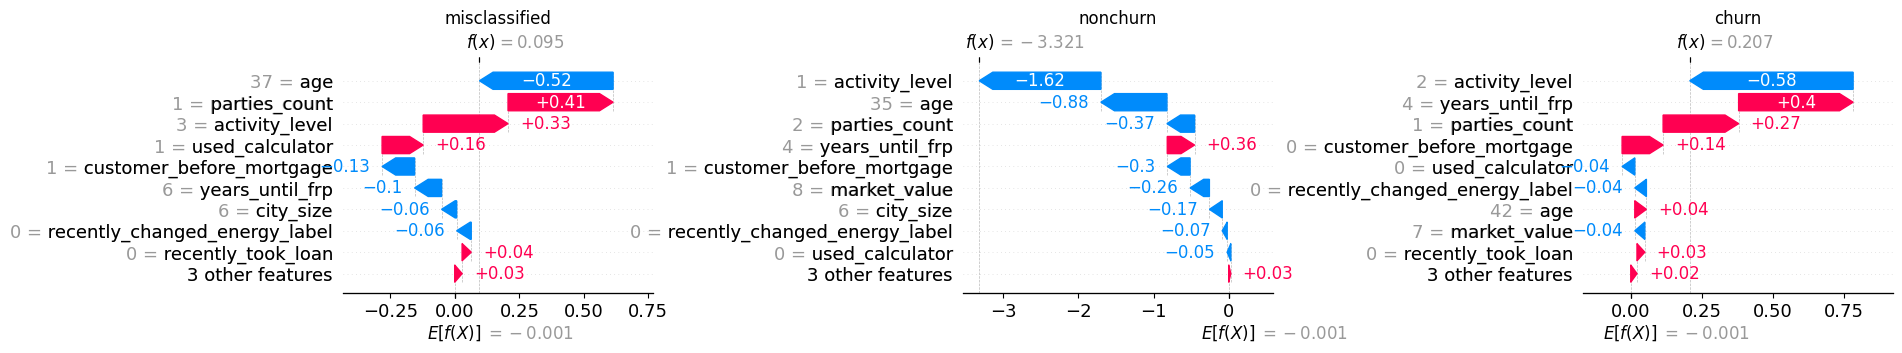

In [12]:
#Find sample that was misclassified, churned and non churned
misclass_idx = np.where((y_test != y_pred))[0][0]
class_1_idx = np.where((y_test == 1) & (y_pred == 1))[0][0]
class_0_idx = np.where((y_test == 0) & (y_pred == 0))[0][0]

titles = ['misclassified', 'nonchurn', 'churn']
samples = [misclass_idx, class_0_idx, class_1_idx]
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
for i, axx in enumerate([ax0,ax1,ax2]):
    plt.sca(axx)
    # Plot the SHAP waterfall plot for each prediction category using the i-th SHAP values
    # shap_values_all[i] contains SHAP values for each category (e.g., misclassifications, non-churn, churn)
    shap.plots.waterfall(shap_values_all[samples[i]],show=False) ## EXERCISE: Fill samples
    axx.set_title(titles[i])
    axx.yaxis.label.set_fontsize(10)
plt.subplots_adjust(wspace=1)
fig.set_size_inches(20, 3)
plt.show()

<details>
<summary>Discussion of the results</summary>


**Discussion of results**<br>
The above plots show us what the effect of the variable is on the outcome for that specific *customer*. A positive red arrow means the feature has a positive impact on churn and a negative blue arrow means the feature value for that customer impacts the churn negatively.

This effect is not always intuitive or understandable, it's just a reflection of what the model learned from the train dataset. This is because causality cannot be proven with this kind of model.

</details>

## 1.3  Bonus: Comparing SHAP explanations with different background samples
In this exercise, you will compare SHAP explanations using different background samples. The goal is to see how feature importance changes when using default background data versus a subset of higher activity customers as the background. You will look at:

* SHAP values that are generated using the default background sample.  
* SHAP values that are generated using higher activity levels as the background for the explainer.  

We use the SHAP with TreeExplainer. The SHAP TreeExplainer is a specialised implementation of the SHAP designed specifically for tree-based models like XGBoost. Background data is not needed, because the algorithm exploits the structure of tree-based models, allowing it to efficiently compute SHAP values without requiring a reference dataset for comparison. The internal splits of decision trees inherently capture the necessary distributional information to explain the model’s predictions. However, in other explainers providing background data is vital, so we want to touch upon how this affects our results.

This shows how the choice of background data impacts the interpretation of feature importance for specific subsets of the population.  <br>

**⭐ Exercise:**<br>
The background data is used to define coalitions, which helps in calculating SHAP values. It is given as second argument in *explainer = shap.Explainer(model, background_data)*.

The subset given in *explainer.shap_values(plotted_data)* will be used for generating the SHAP plots,
allowing us to visualize how this specific subset behaves in relation to the model's predictions.
<br><br>
What do you do:
Based on [EDA](#EDA) choose appropiate activity level that would describe a subset of people more likely to churn based on their activity

 99%|===================| 8408/8483 [00:31<00:00]       

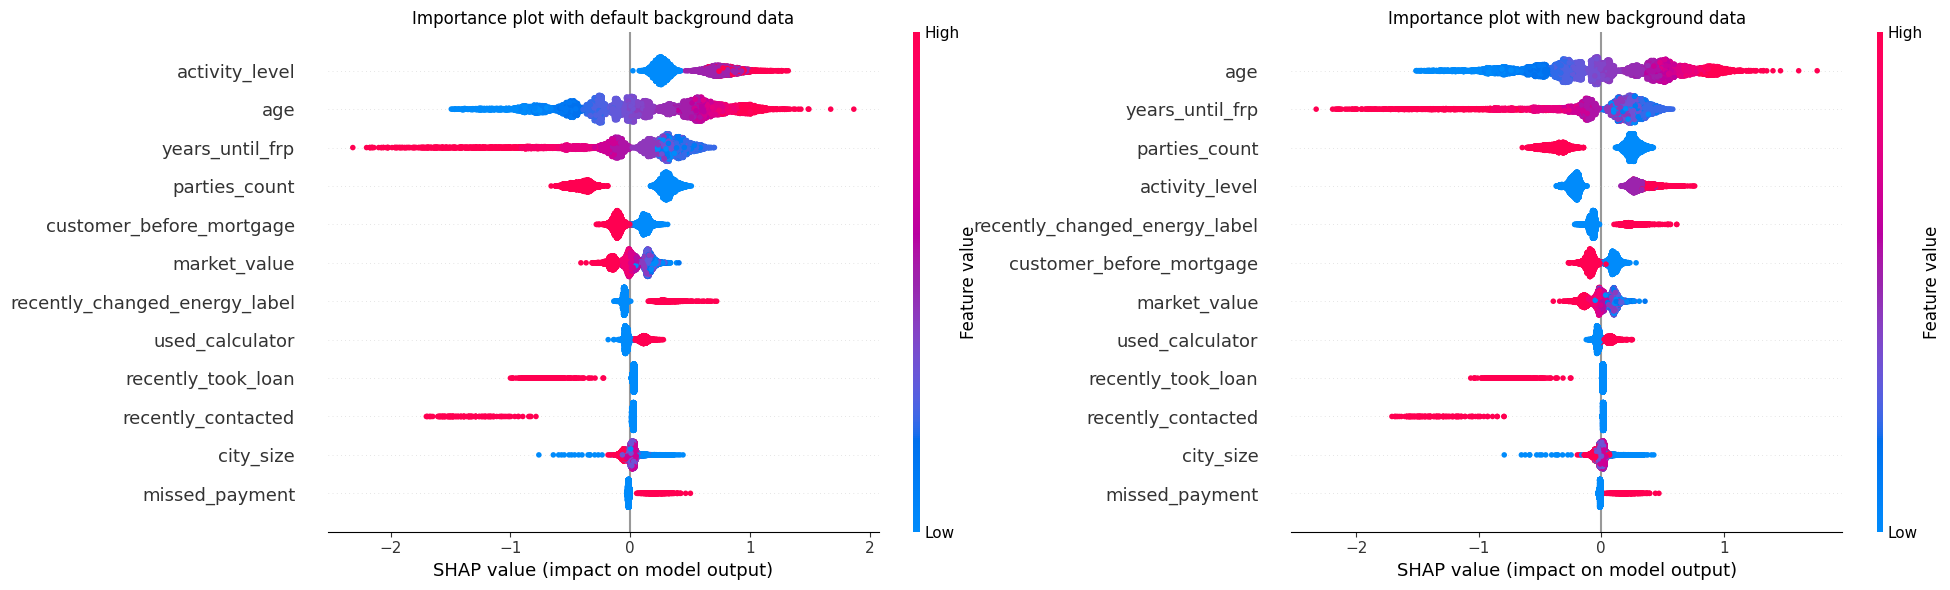

In [13]:
# Subset of the test data where 'activity_level' is greater than X
# This subset will be used in both SHAP plots
dataShap_sub = X_test[X_test['activity_level']>2] # EXERCISE: fill in desired activity level thresold used in both plots

# Subplot 1: SHAP summary plot with the default background dataset (training data)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1,2,1)
shap_values_sub = explainer.shap_values(dataShap_sub)
shap.summary_plot(shap_values_sub, dataShap_sub, plot_size=None,show=False)
plt.title('Importance plot with default background data')

# Subplot 2: SHAP summary plot using the filtered subset as the new background dataset
plt.subplot(1,2,2)
explainer_newbackground = shap.TreeExplainer(xg_cls, dataShap_sub) # add our defined dataSubset as second argument
shap_values_newbackground = explainer_newbackground.shap_values(dataShap_sub)
shap.summary_plot(shap_values_newbackground, dataShap_sub, plot_size=None,show=False)
plt.title('Importance plot with new background data')
plt.show()

<details>
<summary>Discussion of the results</summary>

**Discussion of the results**<br>
We can see here that, for the same samples shown, we obtain different feature importance and distributions of activity levels. While we can now investigate in detail what is truly important for this subset of customers, it is also important to remember that background data cannot be any sample and should be carefully considered. <br>

*Advantages:*<br>
We can see variation of importance for subsets of data. <br>

*Pitfalls:* <br>
Taking random small sample for background data (to improve computational time) can lead to wrong interpretations.
</details>

# 2. Exercise Two: SHAP and features interactions

Earlier, during the EDA we've looked at the correlations. We've seen some moderately correlated relationships between features. In this exercise we will look at the combination of SHAP and correlated features.






### 2.1 SHAP and clusters dendrogram
 In this exercise, we'll visualize these relationships using a dendrogram to cluster correlated features. In addition, we use this clusters to order the SHAP values according to this dendrogram.

Grouping features in SHAP plots allows us to identify relationships among features, making it easier to understand their collective impact on model predictions. This simplification reduces complexity, enabling us to focus on key feature groups rather than individual features.

Let's summarize the correlations of the moderately correlated variables in our dataset.

In [14]:
corr_matrix = corr_matrix.drop(index=['churn', 'balance'], columns=['churn', 'balance'])

# Define correlation thresholds
# weak_threshold: Minimum correlation value to be considered weak but not moderate
# moderate_threshold: Maximum correlation value to be considered weak (i.e., below this is weak)
weak_threshold = 0.3
moderate_threshold = 0.5

# Create a mask that filters correlations between weak_threshold and moderate_threshold
# abs() is used to ensure we are considering the absolute correlation values (both positive and negative correlations)
# The mask will be True for correlations that meet the weak correlation criteria
mask = (corr_matrix.abs() >= weak_threshold) & (corr_matrix.abs() < moderate_threshold)
# Apply the mask to the correlation matrix to extract weak correlations
# where() keeps only the correlations that match the mask, and all others are set to NaN
moderate_correlations = corr_matrix.where(mask)
# Drop rows and columns where all values are NaN (i.e., where no correlations met the weak criteria)
moderate_correlations.dropna(how='all', axis=0).dropna(how='all', axis=1)

,activity_level,used_calculator,market_value,city_size
activity_level,NaN,0.465785,-0.381683,NaN
used_calculator,0.465785,NaN,-0.335742,NaN
market_value,-0.381683,-0.335742,NaN,0.463528
city_size,NaN,NaN,0.463528,NaN


Now let's analyze the relationships between features using hierarchical clustering to identify groups of correlated features within our dataset. We visualize this clustering in a dendrogram.

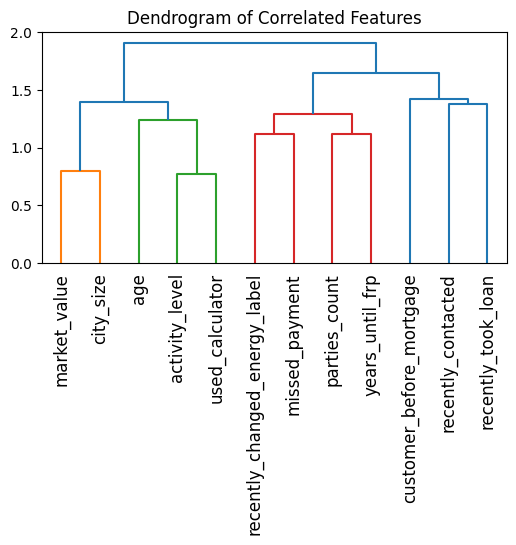

In [15]:
# Perform hierarchical clustering
# '1 - abs(corr_matrix)' converts the correlation matrix into a distance matrix
# Hierarchical clustering requires a distance matrix, and by subtracting from 1, we treat high correlations as "close" and low correlations as "far"
# 'method="ward"' is used to minimize the variance of the clusters being merged
linkage_matrix = linkage(1 - abs(corr_matrix), method='ward')

# Generate the dendrogram
# 'labels=corr_matrix.columns' ensures the feature names (columns) are displayed on the x-axis
# 'leaf_rotation=90' rotates the feature labels for readability
plt.figure(figsize=(6,3))
dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=90)
plt.title("Dendrogram of Correlated Features")
plt.show()


<details>
<summary>Discussion of results dendrogram</summary>

**Discussion of results**<br>
The dendrogram shows four clusters of features. The first cut-off in the dendrogram is at 0.8. At this value activity_level and used_calculator are clustered. Also market_value and city_size have almost the same cut-off value.
</details>

**⭐ Exercise:**<br>
Above, we have a dendrogram that shows the features closest to each other. We can organize SHAP values according to the clusters in the dendrogram from most important to least important in groups (when applicable).<br>

What to do: In the bar plot below use a clustering method and base it on the dendrogram above. Additionally, set a cutoff value for the minimum distance to capture only the most reliable relationships.

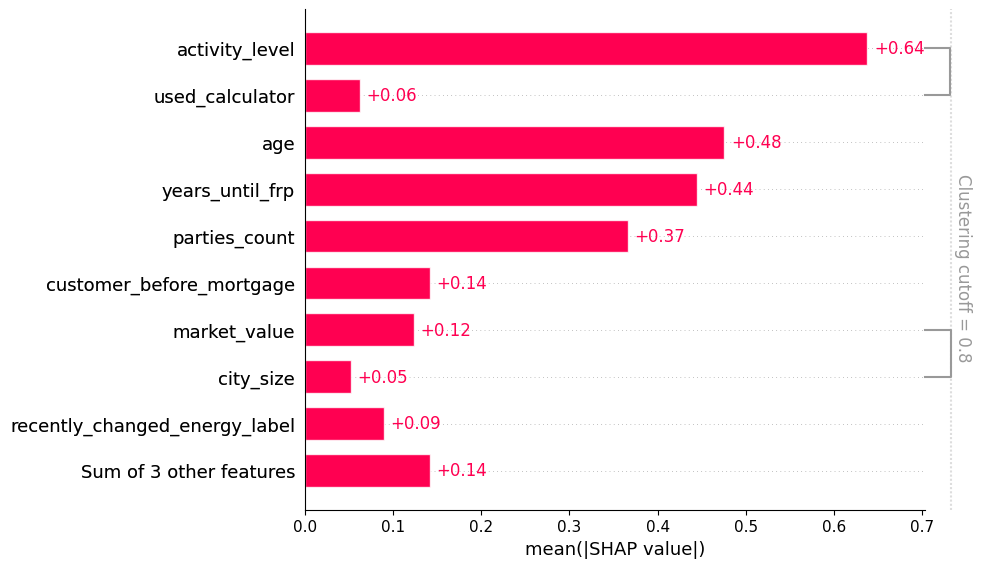

In [16]:
# Generate a SHAP bar plot with hierarchical clustering

# The hierarchical clustering outcomes are passed as the 'clustering' argument
# 'clustering_cutoff=X' controls where the dendrogram will be cut off to form clusters.
# Features below this threshold are grouped together.
shap.plots.bar(shap_values_all, clustering=linkage_matrix, clustering_cutoff=0.8)

**⭐ Exercise**<br>
To get a clearer picture of how the clustered features interact, we can use dependence plots. These plots show how SHAP values for one feature change in relation to another (interactive) feature.<br>

What to do: Plot a dependence plot between the top two clustered features.

<Figure size 640x480 with 0 Axes>

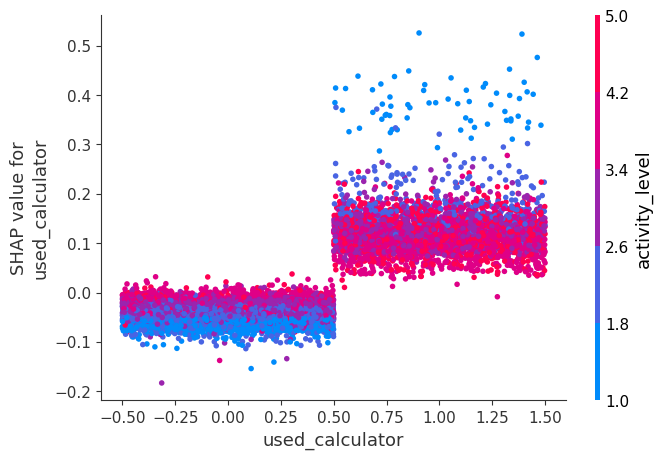

In [17]:
plt.figure()
# SHAP dependence plot for feature 1 showing interaction with feature 2
shap.dependence_plot('used_calculator', shap_values, dataShap, x_jitter=1, interaction_index='activity_level')
plt.show()

<details>
<summary>Discussion of the results</summary>

**Discussion of results**<br>
Activity level and used calculator are connected but not correlated enough to produce issues. It's worth looking at them together, as used calculator is a subset of activity.
From the dependence plot we see:<br>
* for values at 0, SHAP values are mostly near negative and zero, while
* for values = 1, SHAP values are positive.

This indicates a positive impact on predictions when a calculator is used. When calculator was not used, the effect is almost negligible. The color (representing activity_level) is generally uniform, though lower activity levels slightly correspond to lower SHAP values when calulator is not used.
</details>

## 2.2 SHAP and highly correlated features

 In this exercise, you will explore the SHAP values of highly correlated features. Our dataset doesn't have a highly correlated feature, hence we will add it. We will show how SHAP and highly correlated features look like and how to recognise it through explainability.

**Exercise steps**:<br>
* Add two randomly generated highly correlated features to the dataset.
* Calculate the SHAP values and look at the plots.
* ⭐ Make dependence plots.

In [18]:
# Create a copy of the original dataframe to work with
df1 = df.copy()
np.random.seed(0)
# Add a new feature 'n_cos', which is a noisy cosine wave
# np.linspace generates evenly spaced values between 0 and 2*pi over the length of the dataframe
# np.cos calculates the cosine of these values, and np.random.normal adds some random noise to it
df1['n_cos'] = np.cos(np.linspace(0, 2 * np.pi, df.shape[0])) + np.random.normal(0, 0.1, size=df.shape[0])
# Add a feature 'n_correlated_noise_age' that is correlated with the 'age' and 'parties_count' columns
# The feature is calculated as a linear combination of 'age' with random noise and 'parties_count'
# np.random.normal introduces random variation around the age feature, and 0.5 is a scaling factor for both 'age' and 'parties_count'
df1['n_correlated_noise_age'] = df1['age']*0.5*np.random.normal(1, 0.05, size=df.shape[0],)+0.5*df1['parties_count']


In [19]:
# Drop the 'churn' (target) and 'balance' features from the dataframe to create the feature matrix X_c
# 'churn' is the target variable, and 'balance' is excluded from the features
X_c = df1.drop(['churn','balance'],axis=1)
X_train_c, X_test_c, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

xg_cls_c = xgb.XGBClassifier().fit(X_train_c, y_train)

Now let's calculate SHAP plots for our previously tuned model and a new one with correlated features.

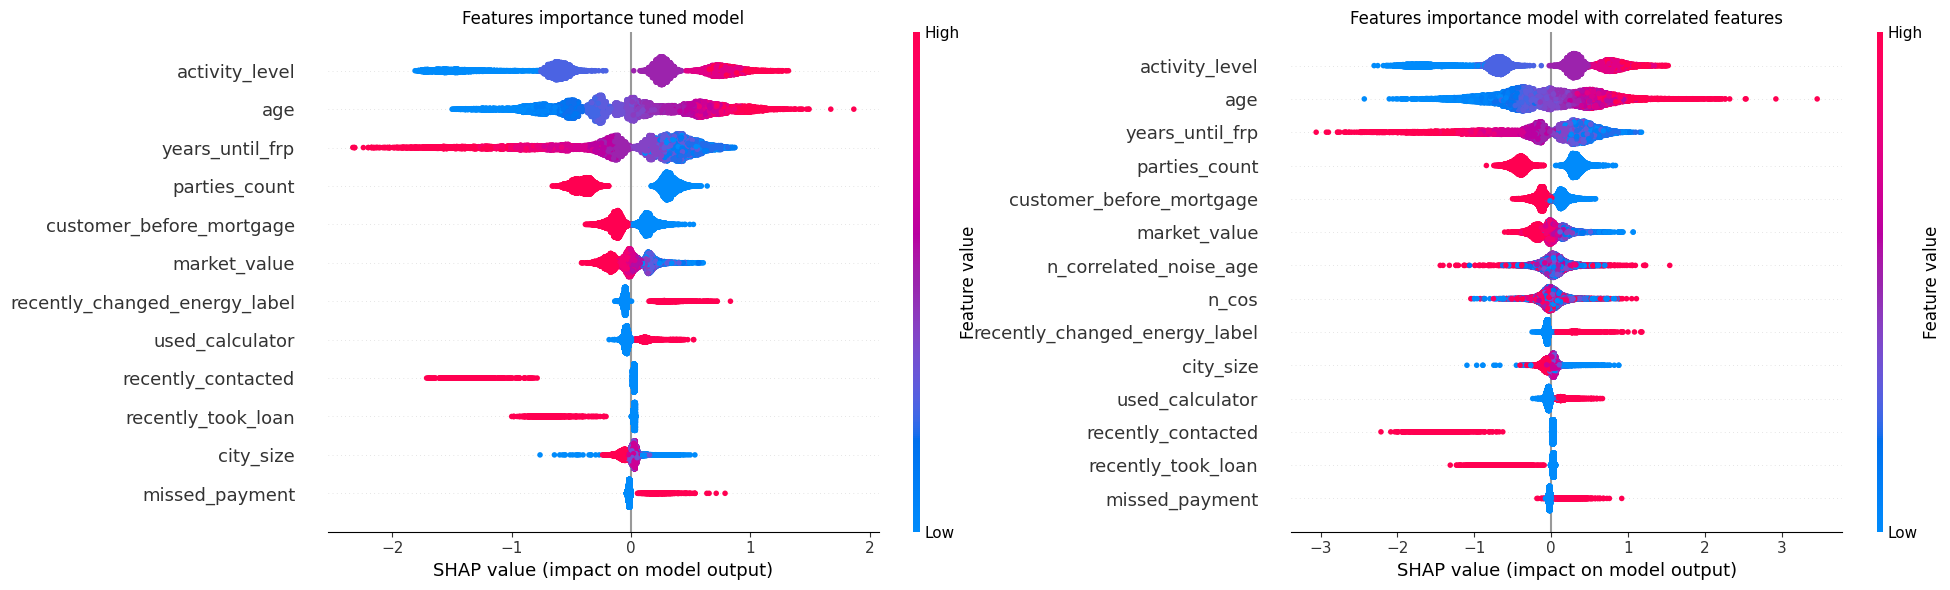

In [20]:
dataShap_c = X_test_c
# Set the test data subset to visualize SHAP values for the model without 'balance' feature
explainer_c = shap.TreeExplainer(xg_cls_c)
shap_values_c = explainer_c.shap_values(dataShap_c)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, dataShap, plot_size=None, show=False)
plt.title('Features importance tuned model')

plt.subplot(1,2,2)
shap.summary_plot(shap_values_c, dataShap_c, plot_size=None, show=False)
plt.title('Features importance model with correlated features')
plt.show()

<details>
<summary>Discussion of the results</summary>

**Discussion of the results**<br>
In the model with correlated features; these features influence the importance of others, causing a redistribution of SHAP values. The plot on the right shows that correlated features introduce noise and redundancy, potentially reducing interpretability. This highlights the benefit of removing or reducing correlated features to create more concise models.<br>

Features ranked below the correlated noise may still be important. These are often unique features that occur infrequently, which is why their importance appears lower in the model.

</details>

**⭐ Exercise**<br>
Plot depenence plot between age and n_correlated_noise_age

<Figure size 640x480 with 0 Axes>

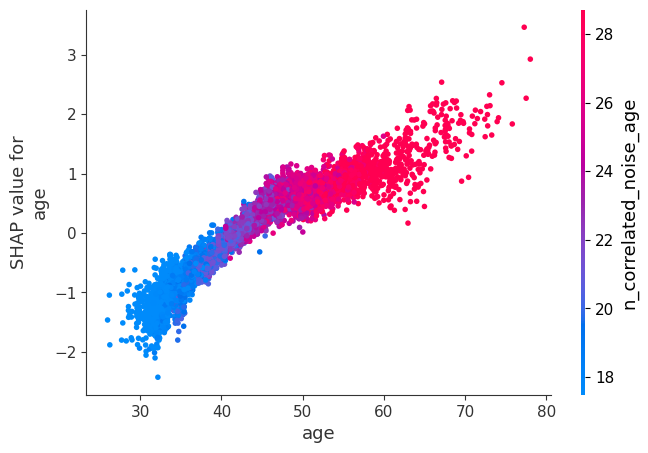

In [21]:
plt.figure()
# SHAP dependence plot for 'age' showing interaction with 'n_correlated_noise_age'
shap.dependence_plot('age', shap_values_c, dataShap_c, interaction_index='n_correlated_noise_age', x_jitter=1)
plt.show()

<details>
<summary>Discussion of the results</summary>

**Discussion of the results**<br>
The depenece plot between age and n_correlated_noise_age shows us that as age (x-axis) increases, SHAP values rise (y-axis), but the correlated feature (n_correlated_noise_age - shown in colour) is redundant. XGBoost effectively handles this, making the feature obsolete as it adds no real value and only introduces noise into the model. It can be safely discarded.

</details>

**⭐ Exercise**<br>
Experiment with different features correlations - fill variable to display. If you don't fill counter variable as in the above plot, it will you show the most interactive one.

<Figure size 640x480 with 0 Axes>

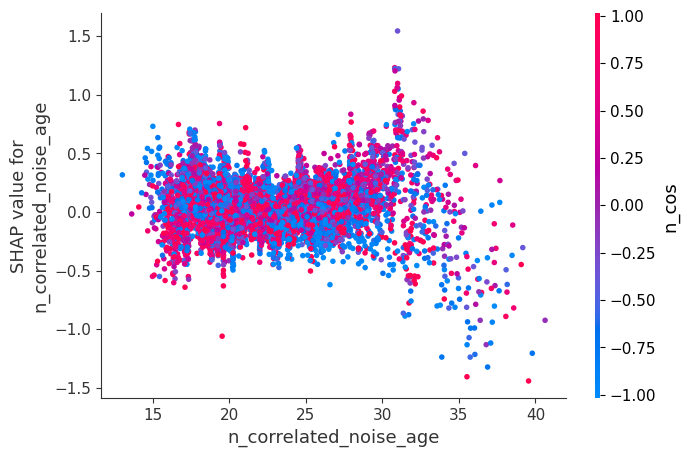

In [22]:
feature = 'n_correlated_noise_age'
plt.figure()
# SHAP dependence plot for 'eature with jitter for better point visibility
shap.dependence_plot(feature, shap_values_c, dataShap_c, x_jitter=1)
plt.show()

# 3. Exercise Three: SHAP clustering
This exercise aims to demonstrate an approach for extracting meaningful insights from our data and model to enhance explainability and interpretability. SHAP is a valuable tool for data scientists and developers to understand how their models make certain decisions. However, the corresponding plots and numbers may not be familiar to business stakeholders. To provide more business-oriented and easily understandable insights, we can leverage a new clustering technique that uses SHAP values to represent our data. Later, we use Skoperules to generate rules that help in understanding the characteristics of our clusters. The process is as follows:
1. After training the model, calculate the SHAP values for our dataset.
2. Use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to reduce the dimensionality of the SHAP values to 2D.
3. Apply [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) to cluster the 2D embeddings of the SHAP values.
4. Finally, use [Skoperules](https://skope-rules.readthedocs.io/en/latest/index.html) to extract more interpretable and linguistically understandable rules within each cluster.

*Remark:* In exercises 3.1 and 3.2 you only need to run the code.



## 3.1 Calculate SHAP values
Calculate SHAP values to understand the contribution of each feature to the model's predictions. We'll do it on a subsample due to long run times.

In [23]:
def get_shap_values(model: BaseEstimator, X: pd.DataFrame) -> np.ndarray:
    """
    Compute SHAP values for the given model and data.

    Args:
        model (BaseEstimator): Trained machine learning model.
        X (pd.DataFrame): Feature data.

    Returns:
        np.ndarray: SHAP values.
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X).values
    return shap_values

# Let's take subsample for speed
data_cluster = X_train.copy(deep=True)
data_cluster['churn'] = y_train
data_cluster = data_cluster.sample(20000, random_state = 42)
X_cluster = data_cluster.drop('churn',axis=1)
y_cluster = data_cluster['churn']

shap_values_train = get_shap_values(xg_cls, X_cluster)
print(f"SHAP array size: {shap_values_train.shape}")

SHAP array size: (20000, 12)


## 3.2 UMAP dimensionality reduction
**UMAP** is a dimensionality reduction technique that preserves the local structure of high-dimensional data while effectively capturing its global structure, making it ideal for visualizing complex datasets in lower dimensions. Now, let's apply **UMAP** to project the high-dimensional SHAP values into two-dimensional space for easier visualization and analysis.

In [24]:
def reduce_dimensionality(data: np.ndarray, n_components: int = 2, min_dist: float = 0, n_neighbors: int = 100) -> np.ndarray:
    """
    Reduce the dimensionality of the given data using UMAP.

    Args:
        data (np.ndarray): Data to reduce dimensionality for.
        n_components (int, optional): Number of dimensions to reduce to. Defaults to 2.
        min_dist (float, optional): Minimum distance between neighboring points. Defaults to 0.
        n_neighbors (int, optional): Number of nearest neighbors to consider. Defaults to 100.

    Returns:
        np.ndarray: Reduced dimensionality data.
    """
    reducer = umap.UMAP(n_components=n_components, n_jobs=2, random_state=42, min_dist=min_dist, n_neighbors=n_neighbors)
    embedding = reducer.fit_transform(data)
    return embedding

embedding = reduce_dimensionality(shap_values_train)
print(f"Embedding size: {embedding.shape}")

Embedding size: (20000, 2)


## 3.3 HDBSCAN clustering
**HDBSCAN** is a density-based clustering algorithm that identifies clusters of varying shapes and sizes which enables discovering complex patterns in large datasets. Utilize **HDBSCAN** to identify and group similar patterns within 2D embeddings of the SHAP values.

In [25]:
def cluster_embeddings(embedding: np.ndarray, min_cluster_size: int, min_samples: int) -> Tuple[hdbscan.HDBSCAN, pd.Series]:
    """
    Cluster UMAP embeddings using HDBSCAN.

    Args:
        embedding (np.ndarray): UMAP embeddings to cluster.
        min_cluster_size (int): Minimum cluster size for HDBSCAN.
        min_samples (int): Minimum samples for HDBSCAN.

    Returns:
        Tuple[hdbscan.HDBSCAN, pd.Series]: HDBSCAN clusterer and cluster labels.
    """
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    cluster_labels = hdbscan_clusterer.fit_predict(embedding)
    return hdbscan_clusterer, pd.Series(cluster_labels)

min_cluster_size = 800
min_samples = 300
hdbscan_clusterer, cluster_labels = cluster_embeddings(embedding, min_cluster_size, min_samples)


📖 To learn more about the 'min_cluster_size' and 'min_samples' parameters in **HDBSCAN** take a look at this informative [blog post](https://walmsley.dev/posts/hdbscan-parameters).

In [26]:
number_of_clusters = cluster_labels.nunique()
print(f"Number of clusters: {number_of_clusters}")

Number of clusters: 10


**2D plot** of **embeddings** with their corresponding cluster labels vs customers that churn.<br>
Do you see any clusters defining mostly churners or non churners?<br>
Tip: samples that didn't match any clustering criteria are labelled -1. Always check if it's not too many of them, otherwise you need to adjust your UMAP parameters.


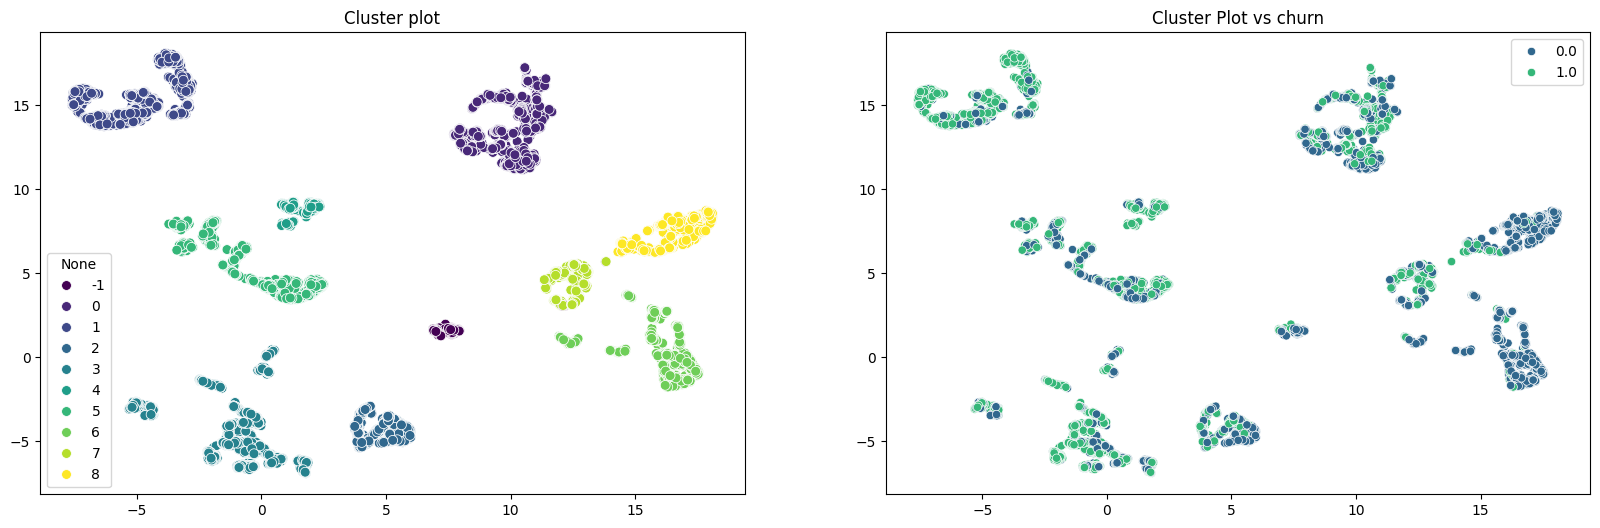

In [27]:
def plot_clusters(embedding: np.ndarray, cluster_labels: pd.Series, target: pd.Series, mask:int = 0) -> None:
    """
    Plot the given points using a scatter plot, coloring them based on cluster labels.

    Args:
        embedding (np.ndarray): Reduced dimensionality data.
        cluster_labels (pd.Series): Cluster labels for coloring points.
        target(pd.Series): Target variable of the model
        mask (int, optional): Indicator if to mask to filter outlier points. Defaults to 0.
    """
    # Filter out points with cluster label -1, since they're outliers
    if mask == 0:
      mask = cluster_labels != -2
    else:
      mask = cluster_labels != -1
    filtered_embedding = embedding[mask]
    filtered_cluster_labels = cluster_labels[mask]
    target = target.reset_index().drop('index',axis=1)[mask]
    #plt.figure(figsize=(10, 8))
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    palette = sns.color_palette("viridis", as_cmap=True)
    plt.subplot(1,2,1)
    if len(filtered_cluster_labels.unique())>2:
      sns.scatterplot(x=filtered_embedding[:, 0], y=filtered_embedding[:, 1], hue=filtered_cluster_labels, palette=palette, legend="full", s=50)
    else:
      sns.scatterplot(x=filtered_embedding[:, 0], y=filtered_embedding[:, 1], hue=filtered_cluster_labels, legend="full", s=50)
    plt.title('Cluster plot')
    plt.subplot(1,2,2)
    sns.scatterplot(x=filtered_embedding[:, 0], y=filtered_embedding[:, 1],hue = target.values.ravel(), palette = sns.color_palette("viridis", 2))
    plt.title("Cluster Plot vs churn")
    plt.show()
plot_clusters(embedding, cluster_labels, y_cluster)

⭐ **Exercise:** \
In this exercise, you will explore how different variables are represented in the clusters. Are there clusters that contain solely specific values?
Check it out!


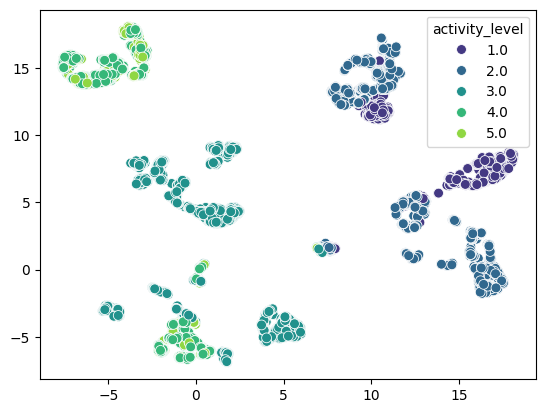

In [28]:
feature = 'activity_level'
feature_vals = X_cluster.reset_index().drop('index',axis=1)[feature]
palette_feat = sns.color_palette("viridis", len(feature_vals.unique()))
plt.figure()
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=feature_vals, legend="full", s=50, palette = palette_feat)
plt.show()

## 3.4 Bonus: Skoperules to extract meaningful insights
**Skoperules** is a rule-based machine learning algorithm that generates interpretable decision rules from clustered data, enabling users to understand and visualize the relationships between features and target variables in an understandable format. Employ **Skoperules** to derive clear and human-readable rules that explain the characteristics of each cluster in our data.<br>
We will extract rules of the clusters, the metris and the churn rate.


In [29]:
number_of_clusters = cluster_labels[cluster_labels!=-1].nunique()

In [30]:
df_clusters = pd.DataFrame(columns=['cluster', 'rule', 'metrics precision, recall)', 'clust_size', 'churn_rate'])
for cluster in range(number_of_clusters):
    X_cluster_r = X_cluster.copy(deep=True)
    X_cluster_r = X_cluster_r.reset_index().drop('index',axis=1)
    mask = cluster_labels != -1
    X_cluster_r_m = X_cluster_r[mask]
    filtered_cluster_labels = cluster_labels[mask]
    y_target = (filtered_cluster_labels == cluster)*1

    churn_rate = y_cluster.reset_index().drop('index',axis=1).loc[y_target[y_target==1].index]
    size_clust = len(churn_rate)
    churn_rate = np.sum(churn_rate)/size_clust

    model = SkopeRules(max_depth = 4, feature_names=X_cluster_r_m.columns.to_list())
    model.fit(X_cluster_r_m, y_target)
    readable_rules = {}
    rules = model.rules_
    if len(rules)>1:
        rules = [rules[0]]
    for rule, metrics in rules:
        new_row = pd.DataFrame({"cluster":cluster,'rule': rule, 'metrics (precision, recall)': [metrics[0:2]],'clust_size':size_clust, 'churn_rate':churn_rate})
        df_clusters = pd.concat([df_clusters, new_row], ignore_index=True)

In [31]:
pd.set_option('display.max_colwidth', None)
display(df_clusters)

,cluster,rule,"metrics precision, recall)",clust_size,churn_rate,"metrics (precision, recall)"
0,0,activity_level <= 2.5 and parties_count <= 1.5,NaN,3118,0.402181,"(1.0, 1.0)"
1,1,activity_level > 3.5 and parties_count <= 1.5 and recently_took_loan <= 0.5,NaN,3527,0.822512,"(1.0, 0.9980998201690847)"
2,2,activity_level <= 3.5 and activity_level > 2.5 and parties_count > 1.5 and years_until_frp > 5.5,NaN,1389,0.341973,"(0.9799400531144676, 1.0)"
3,3,activity_level > 2.5 and parties_count > 1.5 and years_until_frp <= 5.5,NaN,3315,0.618401,"(1.0, 0.7079659134122751)"
4,4,activity_level <= 3.5 and activity_level > 2.5 and years_until_frp <= 5.5 and age > 44.5,NaN,844,0.813981,"(0.647589803436962, 0.9987897790677195)"
5,5,activity_level <= 3.5 and activity_level > 2.5 and parties_count <= 1.5 and age <= 44.5,NaN,2725,0.626789,"(0.9636940290231041, 0.7862241706279177)"
6,6,activity_level <= 2.5 and activity_level > 1.5 and parties_count > 1.5 and years_until_frp > 5.5,NaN,2028,0.143491,"(1.0, 0.8469329119925854)"
7,7,activity_level <= 2.5 and activity_level > 1.5 and parties_count > 1.5 and years_until_frp <= 5.5,NaN,1008,0.460317,"(0.7601202842297038, 0.9739974730122087)"
8,8,activity_level <= 1.5 and parties_count > 1.5 and missed_payment <= 0.5 and used_calculator <= 0.5,NaN,1545,0.070550,"(0.995944125188401, 0.9829874538427036)"


<details>
<summary> Dissucion of the results and next steps </summary>

**Discussion of the results and next steps**<br>
Each of these clusters describes different personas. Some of them have higher probability of churning. In metrics precision and recall describe for us quality of clusters. You can deep dive in specific clusters and use skoperules to identify subgroup of churners within each persona. You simply give Skoperules data with features for only one cluster with target variable of churning instead of cluster number.

# Bonus exercise 1 - simple tree comparison

In this bonus exercise you will compare your results with simple explainable decision tree. A decision tree is composed of nodes and branches. The topmost node is called the root and represents the full dataset. Each internal node represents a feature (or attribute), each branch represents a decision rule, and each leaf node represents an outcome or class label. As you move down the tree, each node splits the data based on a feature. The split of the tree has been performed based on [Gini impurity](https://medium.com/@arpita.k20/gini-impurity-and-entropy-for-decision-tree-68eb139274d1). Each branch leads to another node or a leaf. Decision trees can also provide insights into feature importance. Features that appear closer to the root generally have more influence on the predictions.


Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72      7090
         1.0       0.71      0.72      0.72      7014

    accuracy                           0.72     14104
   macro avg       0.72      0.72      0.72     14104
weighted avg       0.72      0.72      0.72     14104



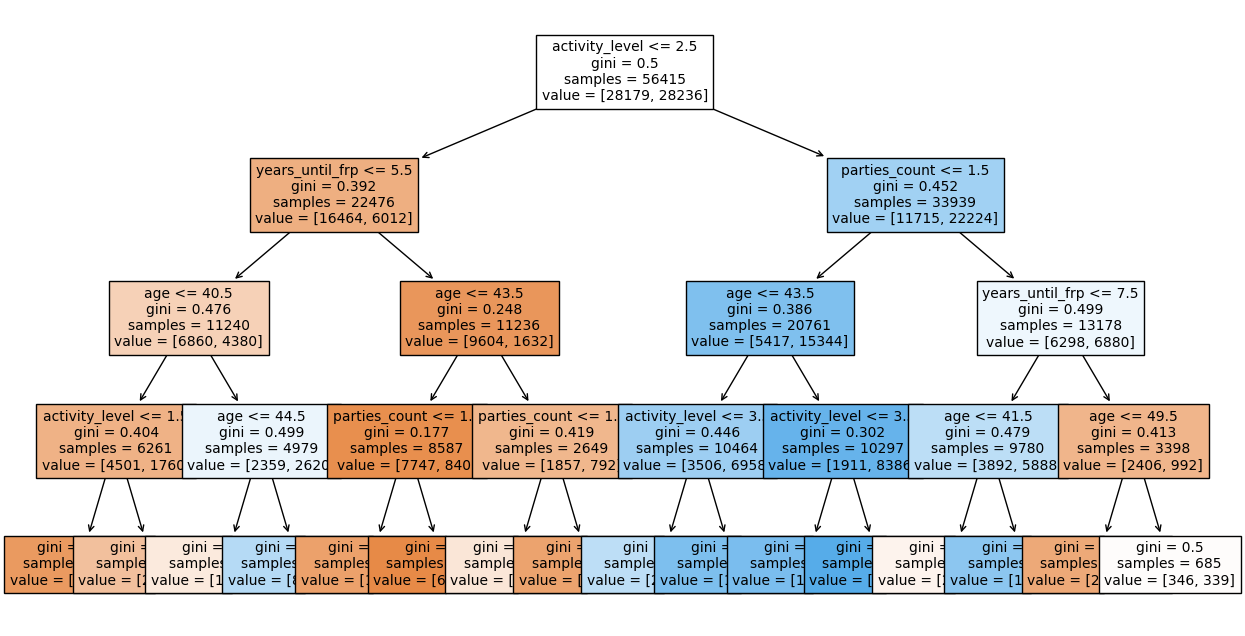

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
X = df.drop(['churn','balance'],axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)
plt.figure(figsize=(15,8))
tree.plot_tree(model, feature_names=list(X.columns), fontsize=10, filled=True)
plt.show()

# Further readings

## SHAP docummentation
Very good source on information, provides examples, issues and of course typical docummentation.
https://shap.readthedocs.io/en/latest/

## SHAP Tree (Explainer)
https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b
https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html

## SHAP dashboard

If you want to interact with your model outcomes/explanations, you can also use shapash library that automatically can create simple interactive dashboard. Example: https://shapash-demo.ossbymaif.fr/

## SHAP clustering
* UMAP<br>
  https://umap-learn.readthedocs.io/en/latest/
* HBDSCAN<br>
  https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html<br>
  https://walmsley.dev/posts/hdbscan-parameters
* Skoperules<br>
  https://skope-rules.readthedocs.io/en/latest/index.html

## Examples of other methods
| Method                      | Description                                                                | Context                                                                                     | Example Libraries                                                                                 |
|-----------------------------|----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Counterfactual Explanations** | Show the smallest change in feature values <br>to alter the prediction.      | Useful for understanding what changes could result <br>in different outcomes, such as loan approvals. | [DICE](https://interpret.ml/DiCE/) |
| **What-If Tool**           | Allows users to change feature values <br>and see how the predictions change.   | Useful for interactive exploration of model behavior <br>and decision-making scenarios.         | [What-If Tool](https://pair-code.github.io/what-if-tool/) |
| **Feature Importances**    | Measures how often a feature is used <br> and how much it helps improve predictions. | Part of tree models                   | [sklearn FI](https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation), [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)|
| **Permutation Feature Importance** | Importance assessed by measuring performance <br>change when a feature is shuffled. | Provides a model-agnostic assessment of feature significance.                               | [sklearn PI](https://scikit-learn.org/stable/modules/permutation_importance.html) |
| **PDP Plots**              | Show the marginal effect of one or two features <br>on the prediction.         | Useful for understanding the relationship between features <br>and predictions.                |  [sklearn PDP](https://scikit-learn.org/stable/modules/partial_dependence.html) |

More on interpretable ML: https://christophm.github.io/interpretable-ml-book/

